In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
# torch.manual_seed(42)

In [3]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device = 'cpu'

print(f'device: {device}')

device: cpu


In [4]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,y,z):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,y,z], dim = 1)    #(N,3)

        for i in range(len(self.layers)-2):
            m = self.linears[i](a)
            a = self.activation(m)


            
        b = self.linears[-1](a) 
         
        return b
    
    def forward_direct(self, x,y,z):
        
        m = torch.cat([x,y,z], dim = 1)    #(N,3)    

        W1 = self.linears[0].weight    # (20,3)

        H_x = W1[:, 0].unsqueeze(0)      # (1,20)
        F_x = torch.zeros_like(H_x)

        H_y = W1[:, 1].unsqueeze(0)      # (1,20)
        F_y = torch.zeros_like(H_y)

        H_z = W1[:, 2].unsqueeze(0)      # (1,20)
        F_z = torch.zeros_like(H_z)


        

        for i in range(len(self.layers)-2):
            L = self.linears[i](m)            # (N,20)
            m = self.activation(L)            # (N,20)
            m_1 = 1.0-torch.square(m)         # (N,20)

            G_x = m_1*H_x     #\sigma'(L)*H   # (N,20)
            G_y = m_1*H_y
            G_z = m_1*H_z
            

            C_x = (-2*m + 2*torch.pow(m,3))*H_x*H_x
            C_y = (-2*m + 2*torch.pow(m,3))*H_y*H_y
            C_z = (-2*m + 2*torch.pow(m,3))*H_z*H_z
          


            E_x = C_x + m_1*F_x    # (N,20)
            E_y = C_y + m_1*F_y    # (N,20)
            E_z = C_z + m_1*F_z
           


            H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
            F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

            H_y = torch.matmul(G_y,self.linears[i+1].weight.t())
            F_y = torch.matmul(E_y,self.linears[i+1].weight.t())

            H_z = torch.matmul(G_z,self.linears[i+1].weight.t())
            F_z = torch.matmul(E_z,self.linears[i+1].weight.t())


        m = self.linears[-1](m)
         
        # return z, H_x, H_y, H_t, F_x, F_y, F_t
        return m, H_x, H_y, F_x, F_y, H_z, F_z


    # # TENSORIZED
    
    
    # def forward_direct(self, x,t):
        
    #     z = torch.cat([x,t], dim = 1)    #(N,2)      N = 90000
    #     N = z.size(0)

    #     W1 = self.linears[0].weight    # (20,2)

    #     H = W1.unsqueeze(0).expand(N,-1,-1).contiguous()     #(N,20,2)
    #     F = torch.zeros_like(H)

    #     # H_x = W1[:, 0].unsqueeze(0)      # (1,20)
    #     # F_x = torch.zeros_like(H_x)

    #     # H_t = W1[:, 1].unsqueeze(0)      # (1,20)
    #     # F_t = torch.zeros_like(H_t)
        

    #     for i in range(len(self.layers)-2):
    #         L = self.linears[i](z)            # (N,20)
    #         z = self.activation(L)            # (N,20)
    #         z_1 = 1.0-torch.square(z)         # (N,20)
    #         z_1 = z_1.unsqueeze(-1)           # (N,20,1)

    #         G = z_1*H     #\sigma'(L)*H   # (N,20,2)

    #         # G_x = z_1*H_x     #\sigma'(L)*H   # (N,20)
    #         # G_t = z_1*H_t                     # (N,20)

    #         z_2 = (-2*z + 2*torch.pow(z,3))   #(N,20)
    #         z_2 = z_2.unsqueeze(-1)           # (N,20,1)

    #         C = z_2*H*H                       # (N,20,2)




    #         # C_x = (-2*z + 2*torch.pow(z,3))*H_x*H_x
    #         # C_t = (-2*z + 2*torch.pow(z,3))*H_t*H_t

    #         E = C + z_1*F                     # (N,20,2)     

    #         # E_x = C_x + z_1*F_x    # (N,50)
    #         # E_t = C_t + z_1*F_t    # (N,50)

    #         H = torch.matmul(G.transpose(1, 2),self.linears[i+1].weight.t()).transpose(1, 2)     # (N,2,20) * (20,1)  = (N,2,1).t() = (N,1,2)
    #         F = torch.matmul(E.transpose(1, 2),self.linears[i+1].weight.t()).transpose(1, 2)     # (N,1,2)


    #         # H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
    #         # F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

    #         # H_t = torch.matmul(G_t,self.linears[i+1].weight.t())
    #         # F_t = torch.matmul(E_t,self.linears[i+1].weight.t())

    #     z = self.linears[-1](z)

    #     H_x = H[:, 0, 0].unsqueeze(-1)   # (N,1)
    #     H_t = H[:, 0, 1].unsqueeze(-1)   # (N,1)
    #     F_x = F[:, 0, 0].unsqueeze(-1)   # (N,1)
    #     F_t = F[:, 0, 1].unsqueeze(-1)   # (N,1)
         
    #     return z, H_x, H_t, F_x, F_t
    


In [5]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([3,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [6]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [6]:
# Create the training data

x = torch.linspace(0,1,30).view(-1,1)
y = torch.linspace(0,1,30).view(-1,1)
z = torch.linspace(0,1,30).view(-1,1)



if torch.is_tensor(x) != True:         
    x = torch.from_numpy(x)  
if torch.is_tensor(y) != True:         
    y = torch.from_numpy(y) 
if torch.is_tensor(z) != True:         
    z = torch.from_numpy(z) 


#convert to float
x = x.float()
y = y.float()
z = z.float()

    
x_train,y_train,z_train = torch.meshgrid(x.squeeze(),y.squeeze(),z.squeeze(), indexing = 'xy')

# x_train = x_train.reshape(-1,1).to(device)    
# y_train = y_train.reshape(-1,1).to(device) 
# z_train = z_train.reshape(-1,1).to(device)
     

x_train = x_train.reshape(-1,1)     
y_train = y_train.reshape(-1,1) 
z_train = z_train.reshape(-1,1) 

     



In [7]:
# Create boundary points

def generate_boundary_points(N = 10000):
    x_0 = torch.zeros(N,1) ; x_1 = torch.ones(N,1); y_0_1 = torch.linspace(0,1.,N).unsqueeze(-1); z_0_1 = torch.linspace(0,1.,N).unsqueeze(-1)
    # b_l = torch.cat([x_0,ylr], dim = 1); b_r = torch.cat([x_1,ylr], dim = 1)

    y_0 = torch.zeros(N,1); y_1 = torch.ones(N,1); x_0_1 = torch.linspace(0,1.,N).unsqueeze(-1)
    # b_b = torch.cat([xbt,y_0], dim = 1); b_t = torch.cat([xbt,y_1], dim = 1)
    z_0 = torch.zeros(N,1); z_1 = torch.ones(N,1)

    x_0 = x_0.to(device)
    x_1 = x_1.to(device)
    
    y_0 = y_0.to(device)
    y_1 = y_1.to(device)

    z_0 = z_0.to(device)
    z_1 = z_1.to(device)

    x_0_1 = x_0_1.to(device)
    y_0_1 = y_0_1.to(device)
    z_0_1 = z_0_1.to(device)


    return x_0, x_1,  y_0, y_1, z_0, z_1, x_0_1, y_0_1, z_0_1









In [8]:
def pde_residual(x,y,z):
    u = PINN(x,y,z)

    # m, H_x, H_y, F_x, F_y = PINN.forward_direct(x,y,t)
    m, H_x, H_y, F_x, F_y, H_z, F_z = PINN.forward_direct(x,y,z)

    du_dx = H_x
    du_dy = H_y
    du_dz = H_z
    
    du_dx_x = F_x
    du_dy_y = F_y
    du_dz_z = F_z
    
    

    res_pde = du_dx_x + du_dy_y + du_dz_z


    return res_pde

In [9]:
def boundary_condition(x,y,z):

    x_0, x_1,  y_0, y_1, z_0, z_1, x_0_1, y_0_1, z_0_1 = generate_boundary_points()

    u_x_0 = PINN(x_0, y_0_1, z_0_1)
    u_x_1 = PINN(x_1,y_0_1, z_0_1)

    u_y_0 = PINN(x_0_1,y_0,z_0_1)
    u_y_1 = PINN(x_0_1,y_1,z_0_1)

    u_z_0 = PINN(x_0_1,y_0_1,z_0)
    u_z_1 = PINN(x_0_1,y_0_1,z_1)

   

    res_x_0 = u_x_0 - torch.zeros_like(x_0)
    res_x_1 = u_x_1 - ((torch.sin(np.pi * y_0_1)) * (torch.sin(np.pi * z_0_1)))
    res_y_0 = u_y_0 - torch.zeros_like(y_0)
    res_y_1 = u_y_1 - torch.zeros_like(y_1)
    res_z_0 = u_z_0 - torch.zeros_like(z_0)
    res_z_1 = u_z_1 - torch.zeros_like(z_1)
    

    return res_x_0,res_x_1,res_y_0,res_y_1, res_z_0,res_z_1

In [10]:
def compute_losses():
   res_pde = pde_residual(x_train, y_train, z_train) 
   
   res_x_0,res_x_1,res_y_0,res_y_1, res_z_0,res_z_1 = boundary_condition(x_train, y_train, z_train)

   loss_pde = torch.mean(res_pde**2)
   
   loss_bc = torch.mean(res_x_0**2) + torch.mean(res_x_1**2) + torch.mean(res_y_0**2) + torch.mean(res_y_1**2) + torch.mean(res_z_0**2) + torch.mean(res_z_1**2)

   total_loss = loss_pde + loss_bc

   return total_loss

In [33]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# No. of epochs


# start_time = time.time()

# num_epochs = 10000



# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()

#     if (epoch) % 200 == 0:
#      print(f'Epoch {epoch}, Loss: {total_loss.item()}')


# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')


    








In [11]:
torch.manual_seed(42)
# PINN = Sequentialmodel(layers).to(device)
PINN = Sequentialmodel(layers)

In [52]:
# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [ ]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# # Threshold loss as the stopping criteria

# max_epochs = 15000
# threshold = 0.002



# start_time = time.time()

# ep = 0
# while ep < max_epochs:
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()


#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at epoch {ep}")
#         break

#     if (ep) % 200 == 0:
#      print(f'Epoch {ep}, Loss: {total_loss.item()}')

#     ep += 1


# print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")





In [12]:
# Using LBFGS

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

max_outer_steps = 15000
threshold = 0.002

start_time = time.time()
ep = 0


def closure():

    optimizer.zero_grad()
    total_loss = compute_losses()
    total_loss.backward()

    return total_loss

while ep < max_outer_steps:

    total_loss = optimizer.step(closure)

    if total_loss.item() < threshold:
        print(f"Reached threshold loss {threshold} at outer step {ep}")
        break

    if ep % 200 == 0:
        print(f'Outer {ep}, Loss: {total_loss.item()}')

    ep += 1

print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")
    

Outer 0, Loss: 2.2101128101348877
Reached threshold loss 0.002 at outer step 113
Training stopped at outer step 113, total time 221.77 s


In [ ]:
# # Memory usage after training

# if device.type == 'cuda':
#     peak_mem = torch.cuda.max_memory_allocated(device)
#     print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  4400.62 MB


In [13]:
import math

def u_closed_form_3D(x, y, z):
    pi = torch.tensor(math.pi)
    r2 = torch.sqrt(torch.tensor(2.0))
    d = torch.sinh(pi * r2)
    sol = (torch.sinh(pi * r2 * x) / d) * torch.sin(pi * y) * torch.sin(pi * z)
    return sol

In [14]:
x_test = torch.linspace(0,1,20).view(-1,1)
y_test = torch.linspace(0,1,20).view(-1,1)
z_test = torch.linspace(0,1,20).view(-1,1)




# if torch.is_tensor(x_test) != True:         
#     x_test = torch.from_numpy(x_test)  
# if torch.is_tensor(y_test) != True:         
#     y_test = torch.from_numpy(y_test) 


# #convert to float
# x = x_test.float()
# y = y_test.float()


    
# x_test,y_test = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'xy')
x_test,y_test,z_test = torch.meshgrid(x_test.squeeze(),y_test.squeeze(),z_test.squeeze(), indexing = 'ij')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


x_test = x_test.reshape(-1,1)     
y_test = y_test.reshape(-1,1) 
z_test = z_test.reshape(-1,1)


u_true = u_closed_form_3D(x_test, y_test, z_test).reshape(20,20,20) 


u_pred = PINN(x_test,y_test,z_test).reshape(20,20,20) 

mse = torch.mean((u_pred - u_true)**2).item()
print(f"MSE vs closed-form: {mse:.3e}")

MSE vs closed-form: 1.570e-03


In [15]:
def compare(PINN):
    PINN.eval()


    x = torch.linspace(0,1,20).view(-1,1)
    y = torch.linspace(0,1,20).view(-1,1)
    z = torch.linspace(0,1,20).view(-1,1)



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
    x_test,y_test,z_test = torch.meshgrid(x.squeeze(),y.squeeze(),z.squeeze(), indexing = 'ij')
    # x_test,y_test,z_test = torch.meshgrid(x,y,z, indexing = 'ij')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


    x_test = x_test.reshape(-1,1)     
    y_test = y_test.reshape(-1,1) 
    z_test = z_test.reshape(-1,1)


    u_true = u_closed_form_3D(x_test, y_test,z_test).reshape(20,20,20) 


    u_pred = PINN(x_test,y_test,z_test)

    u_pred_np = u_pred.reshape(20,20,20).detach().cpu()



    # Plot three orthogonal mid-slices with shared color scale
    vmin = 0.0
    vmax = float(torch.max(u_true))  # ~1.0
    ix = 20 // 2; iy = 20 // 2; iz = 20 // 2

    fig, axs = plt.subplots(3, 2, figsize=(10, 10), constrained_layout=True)

    # Slice x = const (YZ-plane)
    im = axs[0,0].imshow(u_true[ix,:,:].T.cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[0,0].set_title(f"True: x={x[ix].item():.2f}"); axs[0,0].set_xlabel('y'); axs[0,0].set_ylabel('z')
    fig.colorbar(im, ax=axs[0,0])

    im = axs[0,1].imshow(u_pred_np[ix,:,:].T.cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[0,1].set_title(f"PINN: x={x[ix].item():.2f}"); axs[0,1].set_xlabel('y'); axs[0,1].set_ylabel('z')
    fig.colorbar(im, ax=axs[0,1])


    # Slice y = const (XZ-plane)
    im = axs[1,0].imshow(u_true[:,iy,:].T.cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[1,0].set_title(f"True: y={y[iy].item():.2f}"); axs[1,0].set_xlabel('x'); axs[1,0].set_ylabel('z')
    fig.colorbar(im, ax=axs[1,0])

    im = axs[1,1].imshow(u_pred_np[:,iy,:].T.cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[1,1].set_title(f"PINN: y={y[iy].item():.2f}"); axs[1,1].set_xlabel('x'); axs[1,1].set_ylabel('z')
    fig.colorbar(im, ax=axs[1,1])


    # Slice z = const (XY-plane)
    im = axs[2,0].imshow(u_true[:,:,iz].T.cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[2,0].set_title(f"True: z={z[iz].item():.2f}"); axs[2,0].set_xlabel('x'); axs[2,0].set_ylabel('y')
    fig.colorbar(im, ax=axs[2,0])

    im = axs[2,1].imshow(u_pred_np[:,:,iz].T.cpu(), origin='lower', extent=[0,1,0,1],vmin=vmin, vmax=vmax, aspect='equal')
    axs[2,1].set_title(f"PINN: z={z[iz].item():.2f}"); axs[2,1].set_xlabel('x'); axs[2,1].set_ylabel('y')
    fig.colorbar(im, ax=axs[2,1])

    plt.show()

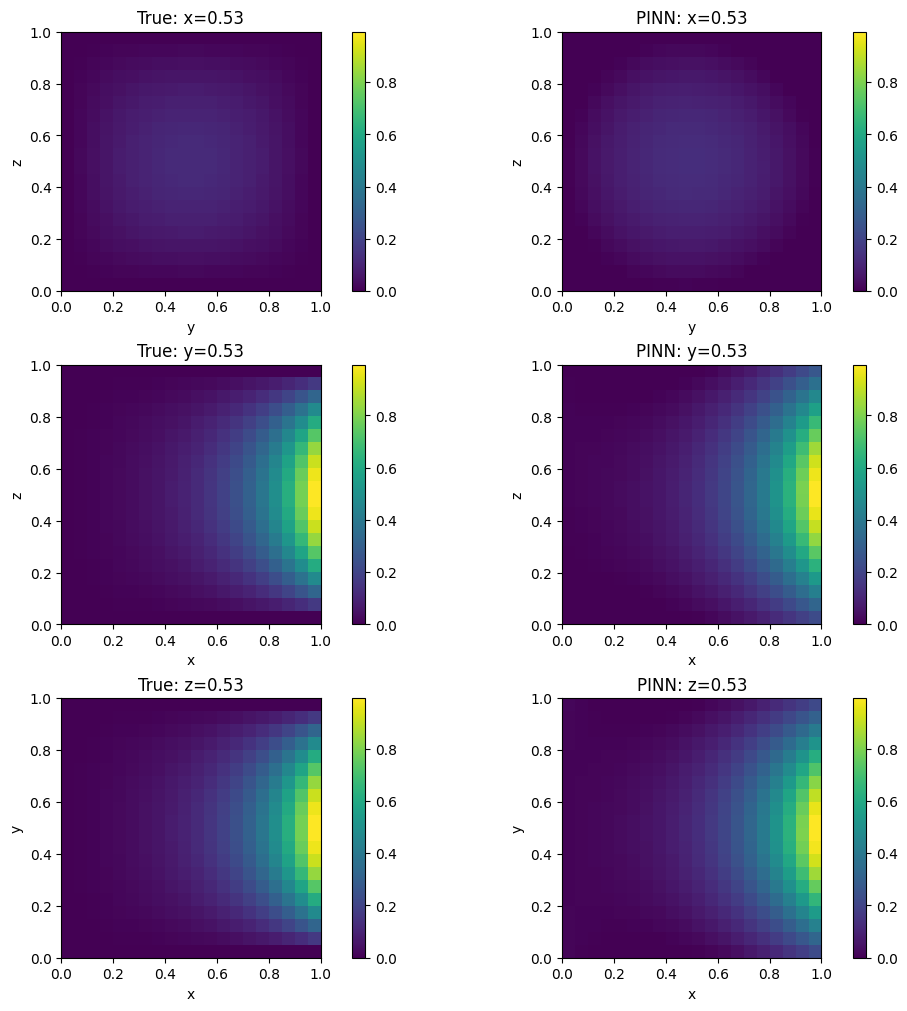

In [16]:
compare(PINN)